In [1]:
!pip install mne
!pip install EDFlib-Python
!pip install autoreject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 72.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mne
import sklearn
from autoreject import AutoReject
from mne.datasets import eegbci
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [3]:
# Read in datafile for the "B," or TA-directed, channel configuration from Data Collection
data = pd.read_csv('B.txt', delimiter = ",", header = None)
print(data.shape)

# Return only data from 8 recorded channels
data = data.iloc[:, 1:9]

(149746, 25)


In [4]:
print(data.shape)
data.head()

(149746, 8)


,1,2,3,4,5,6,7,8
0,4125.416771,20708.310092,198.863470,-2136.670308,2.783188e+06,7469.729480,2.781326e+06,-187500.022352
1,4120.789960,20711.886372,196.494186,-2142.749982,2.783104e+06,7455.849046,2.781387e+06,-187500.022352
2,4081.562648,20705.449069,186.949991,-2149.053174,2.782839e+06,7487.856744,2.783676e+06,-187500.022352
3,4088.804613,20700.039947,192.850851,-2142.370003,2.782607e+06,7506.274582,2.785442e+06,-187500.022352
4,4103.713227,20700.643444,195.331895,-2141.230064,2.782491e+06,7488.594352,2.785924e+06,-187500.022352


In [5]:
# Define channel names, sampling rate, create Raw object with "B" setup data, 
# Data collection information
ch_names = ['Fp1', 'Fp2', 'C1', 'C2', 'P7', 'P8', 'O1', 'O2']

sfreq = 250 
info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
info['experimenter'] = 'Michael Huang, Adan Montes de Oca, Sripad Karne'

raw = mne.io.RawArray(data.transpose(), info)
raw

Creating RawArray with float64 data, n_channels=8, n_times=149746
    Range : 0 ... 149745 =      0.000 ...   598.980 secs
Ready.


<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

In [6]:
# Define all timepoints of data collection as either meditation or questioning 

# Define Meditation based on time-stamps recorded during data-collection via stopwatch
# Define Question period as timestamp + 15 seconds
onset_li = [0, 52.28, 67.28, 121.78, 136.78, 168.14, 183.14, 210.50, 225.50, 249.94, 264.94, 297.32, 312.32, 329.55, 344.55 ,406.04, 421.04, 450.62, 465.62, 483.01, 498.01, 553.49, 568.49]
duration_li = [round(j - i,2) for i, j in zip(onset_li[:-1], onset_li[1:])] + [600 - onset_li[-1]]

description_labels = [1,0] # 1 = Meditation, 0 = Questions
description_li = description_labels*11 + [1]

# Annotations: alternates between meditation and questions 10 times, ends during meditation condition
med_annotations = mne.Annotations(onset= onset_li,  duration= duration_li, description= description_li)
print(med_annotations)

raw.set_annotations(med_annotations)

<Annotations | 23 segments: 0 (11), 1 (12)>


<ipython-input-6-8622d3ec2c50>:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(med_annotations)


<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

Using matplotlib as 2D backend.


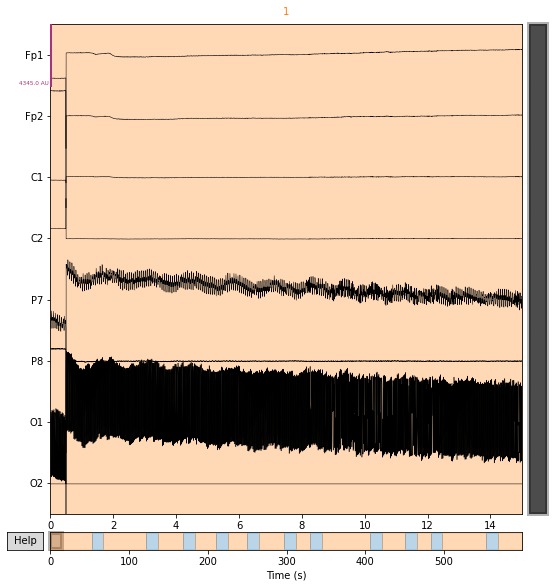

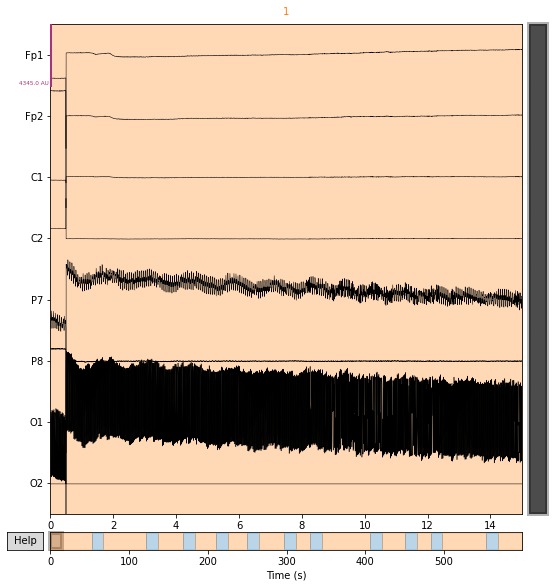

In [7]:
# Sanity check: Orange is meditation, blue is questions
raw.plot(duration = 15, start=0)

In [8]:
# Save annotations to csv for sanity checl
raw.annotations.save('meditation-annotations.csv', overwrite=True)
pd.read_csv('meditation-annotations.csv')

,onset,duration,description
0,1970-01-01 00:00:00.000,52.280,1
1,1970-01-01 00:00:52.280,15.000,0
2,1970-01-01 00:01:07.280,54.500,1
3,1970-01-01 00:02:01.780,15.000,0
4,1970-01-01 00:02:16.780,31.360,1
5,1970-01-01 00:02:48.140,15.000,0
6,1970-01-01 00:03:03.140,27.360,1
7,1970-01-01 00:03:30.500,15.000,0
8,1970-01-01 00:03:45.500,24.440,1
9,1970-01-01 00:04:09.940,15.000,0


In [9]:
raw.load_data()

<RawArray | 8 x 149746 (599.0 s), ~9.2 MB, data loaded>

In [10]:
# Create CSP decoder object defined by LDA
clf = sklearn.pipeline.make_pipeline(mne.decoding.CSP(n_components=4, reg=None, log=True, norm_trace=False), LinearDiscriminantAnalysis())

# Define cross-validation folds and create KFold object
n_splits = 5  
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=189)

In [11]:
# Classification & time-frequency parameters
tmin, tmax = -10, 0 # Same as OpenNeuro Analysis

n_cycles = 12  # Define cycles as 12 to set window size at 0.5 second

# Place bounds on Alpha and Theta Frequency Ranges
min_freq = 4
max_freq = 12
n_freqs = 3  # Define frequency bins to use (nfreqs - 1 will show on plot)

In [12]:
# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # 4-8 Theta Range, 8-12 Alpha Range
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # Define range in list to plot

print(freqs)
print(freq_ranges)

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = ((n_cycles / np.max(freqs)) / 2)
times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(times)

[ 4.  8. 12.]
[(4.0, 8.0), (8.0, 12.0)]


In [13]:
print(times, n_windows)

[-9.5 -9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.
 -2.5 -2.  -1.5 -1.  -0.5] 19


In [14]:
# Read events to Raw object from annotations
# Key: Questions = 1, Meditation = 2
events, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events[:5])

Used Annotations descriptions: ['0', '1']
{'0': 1, '1': 2}
[[    0     0     2]
 [13070     0     1]
 [16820     0     2]
 [30445     0     1]
 [34195     0     2]]


In [15]:
freq_scores = np.zeros((n_freqs - 1,))

le = LabelEncoder()

# Loop through frequency range of Alpha and Theta
for freq, (fmin, fmax) in enumerate(freq_ranges):

    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2) 

    # Apply band-pass filter to isolate Alpha and Theta  
    raw_filter = raw.copy().filter(fmin, fmax, picks = raw.ch_names)

    # Extract epochs
    epochs = mne.Epochs(raw_filter, events, event_dict, tmin - w_size, tmax + w_size, proj=False, baseline=None, preload=True)
    
    print(epochs.events[:, 2])
    y = le.fit_transform(epochs.events[:, 2])

    X = epochs.get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv), axis=0)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 413 samples (1.652 sec)

Not setting metadata
23 matching events found
No baseline correction applied
Using data from preloaded Raw for 23 events and 3501 original time points ...
1 bad epochs dropped
[1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


    Using tolerance 14 (2.2e-16 eps * 8 dim * 7.6e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 71 (2.2e-16 eps * 8 dim * 4e+16  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 8 dim * 8.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 8 dim * 9.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished


[1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 8 dim * 6.9e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 73 (2.2e-16 eps * 8 dim * 4.1e+16  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 14 (2.2e-16 eps * 8 dim * 7.8e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 8 dim * 1e+16  max singular va

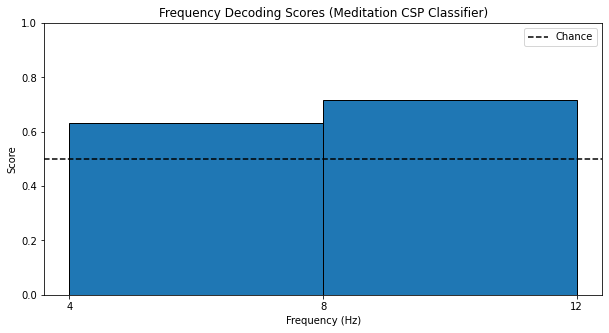

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plots the decoder's score for Alpha and Theta frequencies based on meditation practices
# used during data collection
ax.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0], align='edge', edgecolor='black')

# Ticks
ax.set_xticks(freqs)
ax.set_ylim([0, 1])

# Line indicating chance line
ax.axhline(len(epochs['1']) / len(epochs), color='k', linestyle='--', label='Chance')

# Legend, labels, title
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Score')
ax.set_title('Frequency Decoding Scores (Meditation CSP Classifier)')

fig